# Introduction
The goal of this study is to predict whether a microscopic image of a cell is cancerous or not. A large set of training images has been provided as well as a csv with image IDs and labels. The labels in the CSV consist of a 0 if there is no cancer, and a 1 if there is cancer. Since there are a large number of images, the plan is to use a subset of the images for analysis and model training. The training method that we will use for this study is a convolutional neural network (CNN).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from PIL import Image
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
label_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
tst_img_path = '/kaggle/input/histopathologic-cancer-detection/train'

label_data_raw = pd.read_csv(label_path)
label_data = label_data_raw.copy()
label_data['path'] = label_data['id'] + '.tif'

# Exploratory Data Analysis
A look at the first few rows of the label data demonstrates that it is a pretty simple set, consisting of an "id" column and a "label" column. I used the "id" column (which corresponds to an image filename in the train folder) to create a filename by appending ".tif" to the end.

In [3]:
print(label_data.head())

                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                           path  
0  f38a6374c348f90b587e046aac6079959adf3835.tif  
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif  
2  755db6279dae599ebb4d39a9123cce439965282d.tif  
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif  
4  068aba587a4950175d04c680d38943fd488d6a9d.tif  


In [4]:
file_list = glob.glob(f'{tst_img_path}/*.tif')

In [5]:
print(len(file_list))

220025


We can see that there are a total of 220,025 images in the training folder. Working with this many images will be computationally expensive, so we will work with some subset, generally between 10,000 and 20,000 images.

In [6]:
from IPython.display import display
image_subpath = label_data.sample(n=1000, random_state=10)['path']
colors = pd.DataFrame(columns=['r', 'g', 'b', 'x', 'y'])
for pt in image_subpath:
    image = Image.open(f'{tst_img_path}/{pt}')
    # display(image)

    # print(f'image size: {image.size}')
    image.convert('RGB')
    width, height = image.size
    y = height / 2
    for x in range(0,width):
        r,g,b = image.getpixel((x,y))
        new_row = {'r': r, 'g': g, 'b': b, 'x': x, 'y':y}
        colors.loc[len(colors)] = new_row

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

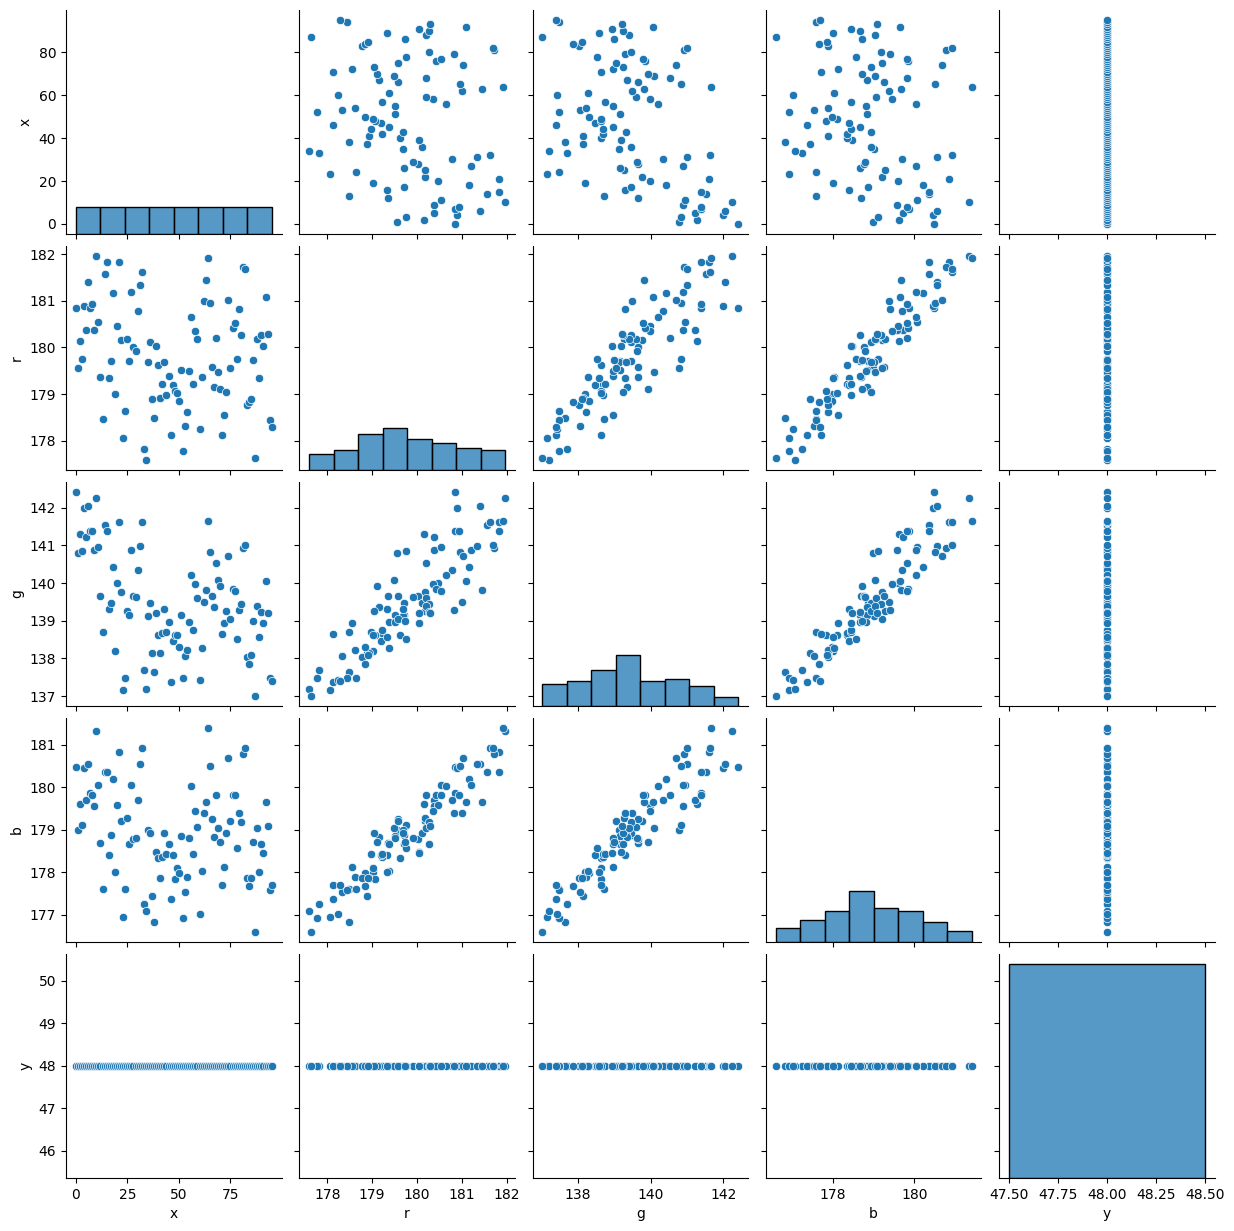

In [8]:

colors = colors.replace([np.inf, -np.inf], 0)
col_grp = colors.groupby(['x']).mean().reset_index()
col_grp = col_grp.replace([np.inf, -np.inf], 0)
sns.pairplot(col_grp)

We pulled the color and coordinate data from the images and plotted them on a pairplot. The first observation is that each individual hue is very linearly correlated with the other hues, so if one hue increases, every other hue usually increases as well. This is likely due to the low color pallet of the images, visually there is not a lot of color range. Another observation from the pairplot is that, on average, there are generally higher amounts of all hues near the edge of the image than there are in the middle.

<Axes: >

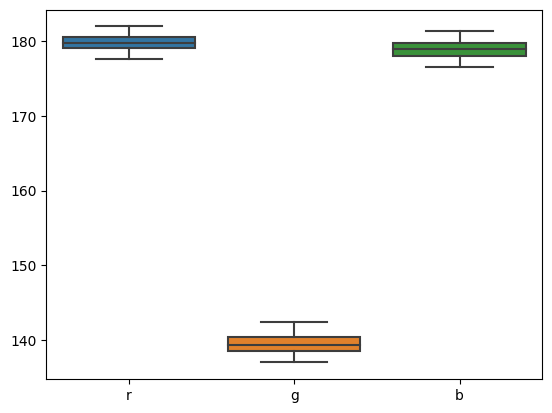

In [9]:

sns.boxplot(col_grp.drop(['x', 'y'], axis=1) )

A boxplot of the color data demonstrates that colors appear to be normally distributed for the most part, but there are more reds and blues than there are greens.

<Axes: xlabel='label'>

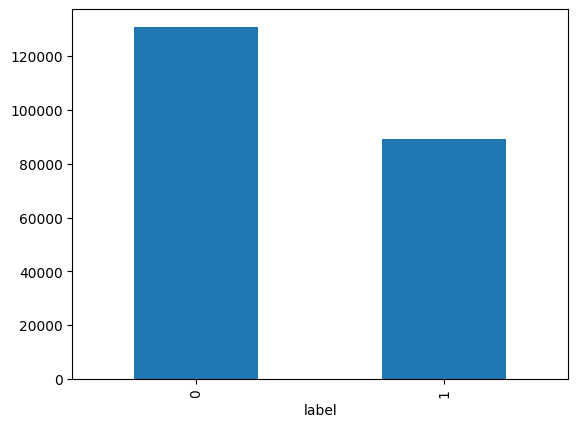

In [10]:
label_cnt = label_data.label.value_counts()
label_cnt.plot(kind='bar')

Labels are not equally distributed. Most of the images (125,000 - 130,000) contain no cancer, and maybe approximately 90,000 do contain cancer. The class balance could be addressed, and might lead to a more robust model. For now, the class counts are close enough for some inital models, so I will ignore this.

# Analysis
The first step will be to sample a selection of the images and convert them into 3D matrices. The keras library, ImageDataGenerator will be used to format the image set as numerical data, and split the sampled set into a training and a validation set. 

In [6]:
#Working with all 220025 images in the test folder is very slow
#I will select 15000 (~8%) and work with them at first
rand_dat = label_data.sample(n=15000, random_state=10)

I will select a random sample of images and create a training and validation set. The images will be vectorized using the ImageDataGenerator library from tensorflow.

In [7]:
%timeit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rand_dat['label'] = rand_dat['label'].astype(str)
dataGen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = dataGen.flow_from_dataframe(dataframe=rand_dat,
                                        directory=tst_img_path,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(96,96),
                                        batch_size=96,
                                        class_mode='binary',
                                        subset='training'
                                        
)

valid_gen = dataGen.flow_from_dataframe(dataframe=rand_dat,
                                        directory=tst_img_path,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(96,96),
                                        batch_size=96,
                                        class_mode='binary',
                                        subset='validation'
                                        
)

Found 12000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


We will be using the keras library to build a convolutional neural net. I will build a simple CNN at first, to get an idea of the basic performance. Then I will introduce more convolutional layers and regularization & dropout layers to address over-fitting, as needed.

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import CenterCrop, Input, BatchNormalization, Activation
from tensorflow.keras.regularizers import l1_l2, l2

In [9]:
#model described to start with-> [Conv-Conv-Maxpool]n
model = models.Sequential()
#add a convolution layer
model.add(layers.Conv2D(48, (3,3), activation='relu', padding='same', input_shape=(96,96,3)))
model.add(layers.Conv2D(48, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(48, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(48, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(24, (3,3), activation='relu', padding='same', input_shape=(24,24,48)))
# model.add(layers.MaxPooling2D((2,2)))



model.add(layers.Flatten())
model.add(layers.Dense(96,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


For the initial model, I will just add 4 convolutional layers, with 2 2x2 maxpooling layers between every two convolutional layers. I will use a 20% drop out layer to hopefully reduce overfitting. 

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 96)                  │       2,654,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,718,097 (10.37 MB)

 Trainable params: 2,718,097 (10.37 MB)

 Non-trainable params: 0 (0.00 B)

After running the model, I found it to overfit quickly around epoch 5, so I reduced learning rate from 0.001 to 0.0001. The model runs better, but still overfits around epoch 14. I will make another model and add some other regularization and convolutional layers to see if the overfitting can be reduced and better accuracies achieved. 

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
model.fit(train_gen, validation_data= valid_gen, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 576ms/step - accuracy: 0.6733 - loss: 0.6042 - val_accuracy: 0.7817 - val_loss: 0.4763
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7668 - loss: 0.4941 - val_accuracy: 0.7837 - val_loss: 0.4719
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.7870 - loss: 0.4684 - val_accuracy: 0.7943 - val_loss: 0.4715
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.7903 - loss: 0.4657 - val_accuracy: 0.7897 - val_loss: 0.4618
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.7969 - loss: 0.4473 - val_accuracy: 0.7923 - val_loss: 0.4562
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.7976 - loss: 0.4415 - val_accuracy: 0.7937 - val_loss: 0.4499
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.8013 - loss: 0.4372 - val_accuracy: 0.7940 - val_loss: 0.4571
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7966 - loss: 0.4414 - val

For the second model, I added 8 convolutional layers with an increasing number of filters and a max pooling layer between every two convolutions. I also added an L1/L2 kernel regularizer on the hidden layer before the final layer with more dropout to hopefully reduce the overfitting of the last model. To start with, I will use a smaller L1 value, so that complex feature interaction is not penalized too much. 

In [32]:
#Working with all 220025 images in the test folder is very slow
#I will select 24000 (~10%) and work with them at first
rand_dat2 = label_data.sample(n=24000, random_state=10)

In [33]:
%timeit
rand_dat2['label'] = rand_dat2['label'].astype(str)
dataGen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
train_gen2 = dataGen.flow_from_dataframe(dataframe=rand_dat2,
                                        directory=tst_img_path,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(96,96),
                                        batch_size=48,
                                        class_mode='binary',
                                        subset='training'
                                        
)

valid_gen2 = dataGen.flow_from_dataframe(dataframe=rand_dat2,
                                        directory=tst_img_path,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(96,96),
                                        batch_size=48,
                                        class_mode='binary',
                                        subset='validation'
                                        
)

Found 16800 validated image filenames belonging to 2 classes.
Found 7200 validated image filenames belonging to 2 classes.


In [34]:
# model2 = models.Sequential([Input(shape=(96,96,3)),
#                             CenterCrop(height=64, width=64)])
model2 = models.Sequential([Input(shape=(96,96,3))])


#add a convolution layer
model2.add(layers.Conv2D(16, (3,3), activation='relu'))
model2.add(layers.Conv2D(16, (3,3), activation='relu'))
model2.add(layers.Conv2D(32, (3,3), activation='relu'))
model2.add(layers.Conv2D(32, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(256, (3,3), activation='relu'))
model2.add(layers.Conv2D(256, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((3,3)))
# model.add(layers.Conv2D(24, (3,3), activation='relu', padding='same', input_shape=(24,24,48)))
# model.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.05)))
model2.add(layers.Dropout(0.6))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 94, 94, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 92, 92, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 88, 88, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 44, 44, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 42, 42, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 40, 40, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 18, 18, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,448,785 (9.34 MB)

 Trainable params: 2,448,785 (9.34 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
opt2 = tf.keras.optimizers.Adam(learning_rate=0.0005)
model2.compile(loss='binary_crossentropy', optimizer=opt2, metrics=['accuracy'])
hist = model2.fit(train_gen2, validation_data= valid_gen2, epochs = 25, callbacks=[es])

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 46s 99ms/step - accuracy: 0.6836 - loss: 4.9969 - val_accuracy: 0.7875 - val_loss: 0.5140
Epoch 2/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.7775 - loss: 0.5145 - val_accuracy: 0.7946 - val_loss: 0.4714
Epoch 3/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.7851 - loss: 0.4979 - val_accuracy: 0.7990 - val_loss: 0.4570
Epoch 4/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.8036 - loss: 0.4709 - val_accuracy: 0.8110 - val_loss: 0.4407
Epoch 5/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.8140 - loss: 0.4543 - val_accuracy: 0.8282 - val_loss: 0.4047
Epoch 6/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.8258 - loss: 0.4340 - val_accuracy: 0.8288 - val_loss: 0.4053
Epoch 7/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.8264 - loss: 0.4257 - val_accuracy: 0.8294 - val_loss: 0.4107
Epoch 8/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.8304 - loss: 0.4202 - val_accurac

# Results

This model achieves a better validation accuracy, and does not seem to overfit for at least the first 20 epochs, with a training accuracy of 0.91 and a validation accuracy of 0.88. It is possible that this model could be run for a few more epochs and get a better accuracy and validation loss, but for now, we will move ahead with it.

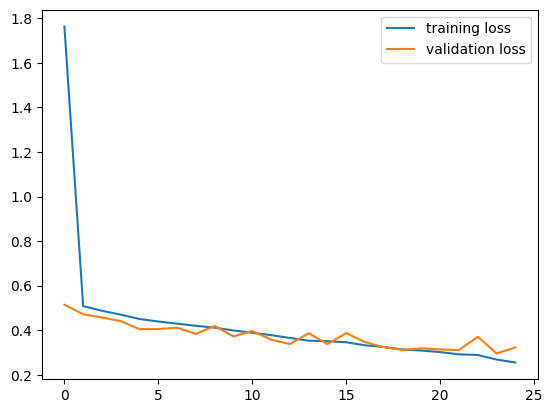

In [36]:

plt.plot(hist.history['loss'], label="training loss")
plt.plot(hist.history['val_loss'], label="validation loss")

plt.legend(loc="upper right")


In [37]:
rand_dat_val = label_data.sample(n=7200, random_state=120)
rand_dat_val['label'] = rand_dat_val['label'].astype(str)
dataGenVal = ImageDataGenerator(rescale=1./255)
valid_gen_val = dataGenVal.flow_from_dataframe(dataframe=rand_dat_val,
                                        directory=tst_img_path,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(96,96),
                                        batch_size=48,
                                        class_mode='binary',
                                        shuffle=False
                                        
)

Found 7200 validated image filenames belonging to 2 classes.


In [38]:

#make some predictions using the validation set
predictions = model2.predict(valid_gen_val)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
conf_matrix = confusion_matrix(valid_gen_val.classes, predictions)
acc = accuracy_score(valid_gen_val.classes, predictions)
print(acc)
print(conf_matrix)

0.8831944444444444
[[3758  506]
 [ 335 2601]]


In [40]:
test_img_path = '/kaggle/input/histopathologic-cancer-detection'
file_list = glob.glob(f'{test_img_path}/*.tif')



The final model does somewhat ok. With more time and tuning, the model could be improved. The next step is to predict the classes for the test data and submit to get a final accuracy.

In [41]:

test_gen = dataGenVal.flow_from_directory(directory=test_img_path,
                                        target_size=(96,96),
                                        color_mode='rgb',
                                        batch_size=96,
                                        class_mode='binary',
                                        shuffle=False,
                                        classes=['test']
                                        
)

Found 57458 images belonging to 1 classes.


In [42]:
img_idx = test_gen.filenames


In [43]:
test_pred = model2.predict(test_gen)
test_pred[test_pred <= 0.5] = 0
test_pred[test_pred > 0.5] = 1

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


599/599 ━━━━━━━━━━━━━━━━━━━━ 277s 458ms/step


In [44]:
#submission is a csv with two columns, id and dataframe
sub = pd.DataFrame(test_pred, columns=['label'])
sub['id'] = img_idx

In [45]:
sub.head()

,label,id
0,1.0,test/00006537328c33e284c973d7b39d340809f7271b.tif
1,1.0,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,1.0,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,0.0,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,0.0,test/000270442cc15af719583a8172c87cd2bd9c7746.tif


In [46]:
sub.id = sub.id.str.replace('.tif', '')
sub.id = sub.id.str.replace('test/', '')
sub.head()

,label,id
0,1.0,00006537328c33e284c973d7b39d340809f7271b
1,1.0,0000ec92553fda4ce39889f9226ace43cae3364e
2,1.0,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.0,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.0,000270442cc15af719583a8172c87cd2bd9c7746


In [47]:
sub.label = pd.to_numeric(sub.label, downcast='integer')
sub.head()

,label,id
0,1,00006537328c33e284c973d7b39d340809f7271b
1,1,0000ec92553fda4ce39889f9226ace43cae3364e
2,1,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0,000270442cc15af719583a8172c87cd2bd9c7746


In [48]:


new_col_order = ['id', 'label']
sub_ordered = sub.reindex(columns=new_col_order)

sub_ordered.to_csv('submission.csv', index=False)


# Conclusion
The final submission using the predictions from the unlabeled test data, returned a private score of 0.7903 and a public score of 0.8288, which is far below some of the top scores for this contest. Given more time, the model could likely be improved by adding:
* Random image rotation
* Better image preparation
* Better class balance and stratification
* More model layer fine-tuning
* A larger training set
